In [137]:
from models.model import AlexNet
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch
import torchvision
from torchvision import transforms, datasets, utils

In [138]:
#device : GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# preparing data
data_transform = {
"train": transforms.Compose([transforms.RandomResizedCrop(224),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
"val": transforms.Compose([transforms.Resize((224, 224)),   # cannot 224, must (224, 224)
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
"test": transforms.Compose([transforms.Resize((224, 224)),   # cannot 224, must (224, 224)
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
                }

batch_size = 8
train_dataset = datasets.ImageFolder(root="data/train", transform=data_transform["train"])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

validate_dataset = datasets.ImageFolder(root="data/val", transform=data_transform["val"])
validate_loader = torch.utils.data.DataLoader(validate_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

test_dataset = datasets.ImageFolder(root="data/test", transform=data_transform["test"])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
cd_list = train_dataset.class_to_idx
cla_dict = dict((val, key) for key, val in cd_list.items())
print(len(cla_dict))


cuda:0
90


In [139]:
model = AlexNet(num_classes=len(cla_dict), init_weights=False)
save_path = "AlexNet.pth"
model.load_state_dict(torch.load(save_path))
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4608, out_features=2048, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, 

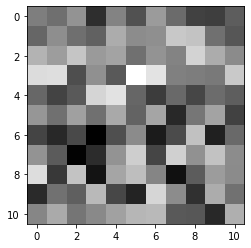

In [140]:
for i in range(48):
    conv1_1 = np.array(model.state_dict()['features.0.weight'])[i]
    img = conv1_1.reshape(11,11,3)
    img_r = img[:,:,0]*225/np.max(img[:,:,0])
    img_g = img[:,:,1]*225/np.max(img[:,:,1])
    img_b = img[:,:,2]*225/np.max(img[:,:,2])
    img_n = (img_r+img_g+img_b)/3
    #img = cv2.normalize(conv1_1.reshape(11,11,3),None,alpha=0,beta=225,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_32F)
    #img = img.astype(np.uint16)
    #print(img_n.shape)
    plt.imshow(img_n, cmap='gray')
    #plt.show()

torch.Size([1, 48, 55, 55])


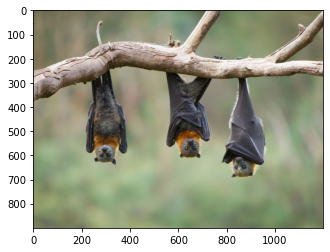

In [141]:
def extract(target, inputs):
    feature = None

    def forward_hook(module, inputs, outputs):
        # 順伝搬の出力を features というグローバル変数に記録する
        global features
        # 1. detach でグラフから切り離す。
        # 2. clone() でテンソルを複製する。モデルのレイヤーで ReLU(inplace=True) のように
        #    inplace で行う層があると、値がその後のレイヤーで書き換えられてまい、
        #    指定した層の出力が取得できない可能性があるため、clone() が必要。
        features = outputs.detach().clone()

    # コールバック関数を登録する。
    handle = target.register_forward_hook(forward_hook)

    # 推論する
    model.eval()
    model(inputs)

    # コールバック関数を解除する。
    handle.remove()

    return features

img = Image.open("data/test/bat/1fd53c0b98.jpg")
transform = data_transform["test"]
inputs = transform(img)
inputs = inputs.unsqueeze(0)
# 抽出対象の層
target_module = model.features[1]  # (1): ReLU(inplace=True)

features = extract(target_module, inputs)
print(features.shape)
plt.imshow(img)

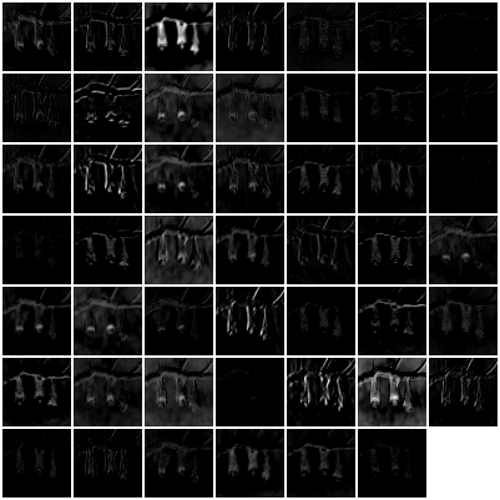

In [142]:
def feature_to_img(feature, nrow=7):
    # (N, H, W) -> (N, C, H, W)
    feature = feature.unsqueeze(1)
    # 画像化して、格子状に並べる
    img = torchvision.utils.make_grid(feature.cpu(), nrow=nrow, normalize=True, pad_value=1)
    # テンソル -> PIL Image
    img = transforms.functional.to_pil_image(img)
    # リサイズする。
    new_w = 500
    new_h = int(new_w * img.height / img.width)
    img = img.resize((new_w, new_h))

    return img

# (1, 48, H, W) のうち、16枚を可視化する。
img = feature_to_img(features[0][:48])
img